# Example calculation of the biological component of DIC in the global oceans

by Greg Pelletier, 22-Mar-2025

The surface water DIC concentration of a given water mass is altered by air–sea gas exchange, the biological production/consumption of organic matter, and calcium carbonate (CaCO3) formation/dissolution (Burt et al, 2016). To isolate the biological component of DIC (DIC_bio), a surface DIC concentration at atmospheric equilibrium (DIC_atm) is computed and subsequently removed from the observed DIC (DIC_obs). 

We use the following equation to represent DICbio:

DIC_bio = DIC_obs – DIC_atm				(eqn 1)


where 

- DIC_obs = observed DIC (OceanSODA-ETHZ)
- DIC_atm = DIC at equilibrium with atmospheric pCO2 and observed TA

We use the DIC reported in OceanSODA-ETHZ as the value of "DIC_obs" in each month at each grid
cell from 1982-2022. Next, we calculate "DIC_atm" with PyCO2SYS using
the atmospheric pCO2 from the SeaFlux data set, combined the observed
TA from OceanSODA-ETHZ in each grid cell for each month from
1982-2022. Therefore, "DIC_atm" represents the hypothetical DIC that
would be in equilibrium with the atmospheric pCO2. Finally, we
calculated the 1982-2022 monthly values of "DIC_bio" using eqn 1 as
DIC_bio = DIC_obs - DIC_atm

The repeating annual cycle of DIC_bio can be represented as a sine function of the following form:

y = mean + amplitude * sin(2π * (x - phase) / period)	(eqn 2)

where 

- y = DIC_bio = DIC_obs – DIC_atm
- x = time as decimal year fraction (1982-2022) 
- mean = mean from sine-regression
- amplitude = amplitude from sine-regression
- phase = phase shift from sine-regression
- period = assumed equal to 1 cycle per year

PyOAE incudes functions "dic_bio" to calculate DIC_bio using eqn 1, and "sine_fit" to find the optimum parameters of the sine-regression model in eqn 2. We solve for the best-fit values of the parameters in eqn 2 at each grid cell including the mean, amplitude, and phase of the sine function at each location. 

In this example we use two netcdf files that we need to do the analysis, OceanSODA_ETHZ_for_PyOAE.nc and SeaFlux_for_PyOAE.nc, available to download at the following link:

https://drive.google.com/drive/folders/1BGgVRk2Gf6mxNnX1Fxg0Q4GtZSAYMzef?usp=sharing

References:
- Clargo et al 2015 (https://doi.org/10.1016/j.marchem.2015.08.010)
- Burt et al 2016 (https://doi.org/10.1002/lno.10243):


**Uncomment one of the following lines to install or upgrade the PyOAE package if it is not already installed**

In [1]:
# !pip install git+https://github.com/gjpelletier/PyOAE.git
# !pip install git+https://github.com/gjpelletier/PyOAE.git --upgrade

**Import packages**

In [1]:
from PyOAE import dic_bio, sine_fit
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time
import multiprocessing

**Read the datasets from the OceanSODA-ETHZ and SeaFlux nc files**

In [2]:
# read the data into an xarray dataset
ds1 = xr.open_dataset("OceanSODA_ETHZ_for_PyOAE.nc", chunks={"x":60})
ds2 = xr.open_dataset("SeaFlux_for_PyOAE.nc", chunks={"x":60})
# Convert ds1 to dictionary of numpy arrays for computations
ds_dict = {var: ds1[var].values for var in ds1.data_vars}
# append yearfrac,lon,lat,time,pco2atm,fco2atm to ds_dict
ds_dict["yearfrac"] = ds1.yearfrac.values
ds_dict["x"] = ds1.x.values
ds_dict["y"] = ds1.y.values
ds_dict["time"] = ds1.time.values
ds_dict["pco2atm"] = ds2.pco2atm.values
ds_dict["fco2atm"] = ds2.fco2atm.values
# extract the dims
NT,NY,NX = ds_dict["talk"].shape

**Transpose and combine x and y into 1d for multiprocessing**

In [3]:
# transpose and reshape arrays
ds_dict_T = {}
ds_dict_T["yearfrac"] = ds1.yearfrac.values
ds_dict_T["talk"] = np.transpose(ds_dict['talk'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["dic"] = np.transpose(ds_dict['dic'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["temperature"] = np.transpose(ds_dict['temperature'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["salinity"] = np.transpose(ds_dict['salinity'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["sio3"] = np.transpose(ds_dict['sio3'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["po4"] = np.transpose(ds_dict['po4'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["ph_total"] = np.transpose(ds_dict['ph_total'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["pco2atm"] = np.transpose(ds_dict['pco2atm'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["fco2atm"] = np.transpose(ds_dict['fco2atm'],(2,1,0)).reshape(NX*NY,NT)
# initialize new output arrays
ds_dict_T["dic_atm"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["dic_bio"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["dic_bio_fit"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["dic_bio_mean"] = np.full((NX*NY), np.nan)
ds_dict_T["dic_bio_amplitude"] = np.full((NX*NY), np.nan)
ds_dict_T["dic_bio_phase"] = np.full((NX*NY), np.nan)
ds_dict_T["dic_bio_rmse"] = np.full((NX*NY), np.nan)
ds_dict_T["dic_bio_adj_rsquared"] = np.full((NX*NY), np.nan)
ds_dict_T["dic_bio_pvalue"] = np.full((NX*NY), np.nan)

**Define a matlab-style tic toc timer to measure how long the computations take**

In [4]:
# matlab-style tic toc timer
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

**Define the function that will calculate DIC_bio during the multiprocessing loop**

In [5]:
# define the function to find the root in each grid cell i
def find_dic_bio(i):
    kwargs = {
        'alkalinity': ds_dict_T["talk"][i,:],
        'dic': ds_dict_T["dic"][i,:],
        'pco2atm': ds_dict_T["fco2atm"][i,:],
        'pco2atm_type': 5,  # The second parameter 4=pCO2, 5=fCO2
        'total_silicate': ds_dict_T["sio3"][i,:],
        'total_phosphate': ds_dict_T["po4"][i,:],
        'temperature': ds_dict_T["temperature"][i,:],
        'salinity': ds_dict_T["salinity"][i,:],
        'total_pressure': 0,
        'opt_pH_scale': 1,  # pH scale (1= total scale)
        'opt_k_carbonic': 10,  # Choice of H2CO3 and HCO3- K1 and K2 (10= Lueker et al 2000)
        'opt_k_bisulfate': 1,  # Choice of HSO4- dissociation constant KSO4 (1= Dickson)
        'opt_total_borate': 1,  # Choice for boron:sal 
        'opt_k_fluoride': 1   # Choice for fluoride
        }
    # nnn = number of non-nan values for each input variable to dic_bio         
    nnn_talk = np.count_nonzero(~np.isnan(kwargs["alkalinity"]))  # number of non-nan
    nnn_dic = np.count_nonzero(~np.isnan(kwargs["dic"]))  # number of non-nan
    nnn_pco2atm = np.count_nonzero(~np.isnan(kwargs["pco2atm"]))  # number of non-nan
    nnn_sio3 = np.count_nonzero(~np.isnan(kwargs["total_silicate"]))  # number of non-nan
    nnn_po4 = np.count_nonzero(~np.isnan(kwargs["total_phosphate"]))  # number of non-nan
    nnn_temp = np.count_nonzero(~np.isnan(kwargs["temperature"]))  # number of non-nan
    nnn_sal = np.count_nonzero(~np.isnan(kwargs["salinity"]))  # number of non-nan
    # print("i in f: ",i) 
    if (nnn_talk==nnn_dic and nnn_talk==nnn_pco2atm and nnn_talk==nnn_sio3 and 
        nnn_talk==nnn_po4 and nnn_talk==nnn_temp and nnn_talk==nnn_sal and nnn_talk > 0):
        # solve for dic_bio = dic_obs - dic_atm
        result_1 = dic_bio(**kwargs)
        # solve for dic_bio vs time sine-regression mean, amplitude, phase, rmse, y_fit
        result_2 = sine_fit(ds_dict_T["yearfrac"],result_1["dic_bio"])  
        # output nested dictionary
        output = {
            'i': i,
            'result_1': result_1,
            'result_2': result_2
            }       
        # print("i in f: ",i) 
        return output

**Multiprocessing loop to find DIC_bio in all grid cells**

We will use a multiprocessing loop to calculate the results in all of the grid cells. This takes about 10 minutes using 6 CPU cores. Note that these calculations would take many times longer if we were not using multiprocessing to parallelize the computations between multiple CPUs. If you are using a Windows laptop, we recommend setting the value of ncpu below equal to the number of performance cores in your laptop for optimum use of your computer resources.

In [6]:
# parallel processing loop through all grid cells
print('Computing DIC_bio, please wait ...')
tic()
ncpu = 6   # number of CPU cores to use for parallel processing
with multiprocessing.Pool(processes=ncpu) as pool:    
    # Use imap_unordered to apply the function to a range of numbers
    results = pool.imap_unordered(find_dic_bio, range(NX*NY))    
    # Iterate over the results as they become available
    for result in results:
        if result is not None:
            i = int(result['i'])
            ds_dict_T["dic_atm"][i,:]= result["result_1"]["dic_atm"]
            ds_dict_T["dic_bio"][i,:] = result["result_1"]["dic_bio"]
            ds_dict_T["dic_bio_fit"][i,:]= result["result_2"]["y_fit"]
            ds_dict_T["dic_bio_mean"][i]= result["result_2"]["mean"]
            ds_dict_T["dic_bio_amplitude"][i]= result["result_2"]["amplitude"]
            ds_dict_T["dic_bio_phase"][i]= result["result_2"]["phase"]
            ds_dict_T["dic_bio_rmse"][i]= result["result_2"]["rmse"]
            ds_dict_T["dic_bio_adj_rsquared"][i]= result["result_2"]["adj_rsquared"]
            ds_dict_T["dic_bio_pvalue"][i]= result["result_2"]["pvalue"]
            # print("i in loop: ",i) 
print('Done')
toc()

Computing DIC_bio, please wait ...
Done
Elapsed time: 617.918485 seconds.



**Reshape and transpose outputs back to original shape of inputs**

In [7]:
ds_dict["dic_atm"] = np.reshape(ds_dict_T['dic_atm'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["dic_bio"] = np.reshape(ds_dict_T['dic_bio'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["dic_bio_fit"] = np.reshape(ds_dict_T['dic_bio_fit'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["dic_bio_mean"] = np.reshape(ds_dict_T['dic_bio_mean'],(NX,NY)).transpose(1,0)
ds_dict["dic_bio_amplitude"] = np.reshape(ds_dict_T['dic_bio_amplitude'],(NX,NY)).transpose(1,0)
ds_dict["dic_bio_phase"] = np.reshape(ds_dict_T['dic_bio_phase'],(NX,NY)).transpose(1,0)
ds_dict["dic_bio_rmse"] = np.reshape(ds_dict_T['dic_bio_rmse'],(NX,NY)).transpose(1,0)
ds_dict["dic_bio_adj_rsquared"] = np.reshape(ds_dict_T['dic_bio_adj_rsquared'],(NX,NY)).transpose(1,0)
ds_dict["dic_bio_pvalue"] = np.reshape(ds_dict_T['dic_bio_pvalue'],(NX,NY)).transpose(1,0)

**Maps of the results**

Next we will make a map showing the results for the regression estimate of the mean DIC_bio. Positive mean values of DIC_bio, shown in red, indcate that the long-term average of DIC_obs > DIC_atm. Negative values of DIC_bio, shown in blue, indicate that long_term average of DIC_obs < DIC_atm. 

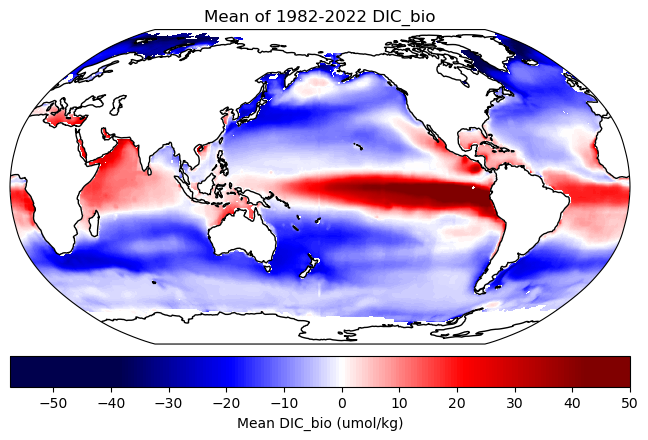

In [8]:
# Robinson map of the sine-regression mean values of DIC_bio
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = ds_dict['dic_bio_mean']
# Define the zero point
vmin = np.nanpercentile(Z,1)
vmax = np.nanpercentile(Z,99)
vcenter = 0.0
# Create a normalization instance
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'Mean of 1982-2022 DIC_bio')
plt.contourf(X,Y,Z,cmap='seismic',levels=256,transform=ccrs.PlateCarree(), norm=norm);
plt.colorbar(orientation="horizontal", pad=0.03,label='Mean DIC_bio (umol/kg)',ticks=[-60,-50,-40,-30,-20,-10,0,10,20,30,40,50]);
plt.savefig('Fig5_map_of_DIC_bio_mean_using_fco2atm_as_fco2_v4.png', format='png', dpi=300)
plt.show()

Next we will make a map showing the results of the regression estimate of the amplitude of DIC_bio. Note that the amplitude represents half of the distance from the peak to the trough of each seasonal cycle. Therefore the amplitude is half of the typical annual range of values of DIC_bio.

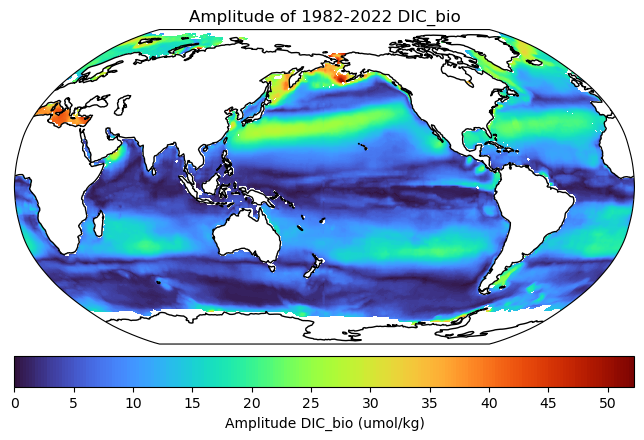

In [9]:
# Robinson map of the sine-regression amplitude values of DIC_bio
import cartopy.crs as ccrs
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = np.abs(ds_dict["dic_bio_amplitude"])
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'Amplitude of 1982-2022 DIC_bio')
plt.contourf(X,Y,Z,cmap='turbo',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label='Amplitude DIC_bio (umol/kg)',ticks=[0,5,10,15,20,25,30,35,40,45,50]);
plt.savefig('Fig6_map_of_DIC_bio_amplitude_using_fco2atm_as_fco2_v4.png', format='png', dpi=300)
plt.show()

In [10]:
print(X.shape)
print(Y.shape)
print(Z.shape)

(360,)
(180,)
(180, 360)


Next we will make a map showing the p-values of the sine-regressions. Most of the grid cells have statistically signficant regressions (p<0.05), except for a narrow near the equator, and some scattered grid cells elsewhere

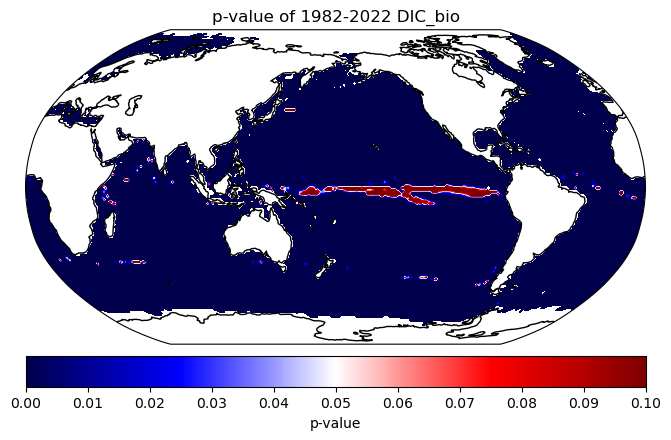

In [21]:
# Robinson map of the sine-regression rsquared values of DIC_bio
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import LinearLocator
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = np.abs(ds_dict['dic_bio_pvalue'])
Z[Z>0.1]=0.1
# Define the zero point
vmin = 0
vmax = 0.1
vcenter = 0.05
# Create a normalization instance
norm = TwoSlopeNorm(vmin=vmin,vcenter=vcenter,vmax=vmax)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
plt.title(r'p-value of 1982-2022 DIC_bio')
plt.contourf(X,Y,Z,cmap='seismic',transform=ccrs.PlateCarree(),norm=norm,levels=256);
cbar = plt.colorbar(orientation="horizontal", pad=0.03,label='p-value',
                    ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]);
plt.savefig('Fig7_map_of_DIC_bio_pvalue_using_fco2atm_as_fco2_v3.png', format='png', dpi=300)
plt.show()

Next, we will make a map showing the adjusted r^2 values for the regressions in each grid cell. Note that the r^2 values tend to be greater in areas that have the largest amplitudes. In other words, the regressions are best in areas where there is the greatest biogeochemical effect in DIC_bio

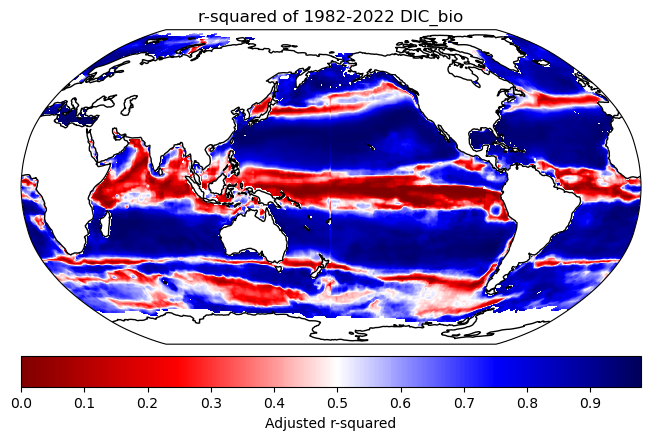

In [23]:
# Robinson map of the sine-regression rsquared values of DIC_bio
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = np.abs(ds_dict['dic_bio_adj_rsquared'])
# Define the zero point
vmin = 0
vmax = 1.0
vcenter = 0.5
# Create a normalization instance
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'r-squared of 1982-2022 DIC_bio')
plt.contourf(X,Y,Z,cmap='seismic_r',transform=ccrs.PlateCarree(), norm=norm,levels=256);
# plt.contourf(X,Y,Z,cmap='plasma',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label='Adjusted r-squared',ticks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]);
plt.savefig('Fig8_map_of_DIC_bio_rsquared_using_fco2atm_as_fco2_v3.png', format='png', dpi=300)
plt.show()

Finally, we will show the time series of DIC_obs, DIC_atm, and DIC_bio at three selected locations in the coastal California Current Ecosystem as follows:

- Columbia River
- San Francisco
- Huntington

Panel "b" in these figures show that the sine-regressions provide a reasonably good representation of the time-series of the typical annual cycles of DIC_bio in various locations.

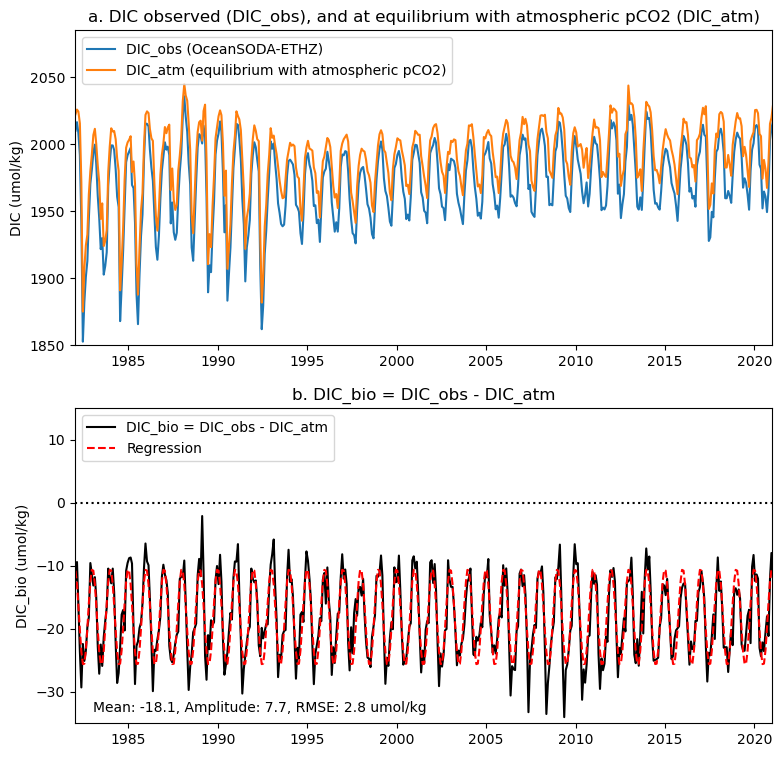

In [24]:
# Columbia River location i,j coordinates
i=234
j=136
fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    ''',
    figsize = (9, 9)
    # constrained_layout = True
)

# Plot at ['A']
ax['A'].plot(ds_dict["yearfrac"], ds_dict["dic"][:,j,i], label='DIC_obs (OceanSODA-ETHZ)', linestyle='-', marker='')
ax['A'].plot(ds_dict["yearfrac"], ds_dict["dic_atm"][:,j,i], label='DIC_atm (equilibrium with atmospheric pCO2)', linestyle='-')
# ax['A'].set_xlabel('year')
ax['A'].set_ylabel('DIC (umol/kg)')
ax['A'].legend(loc='upper left')
# ax['A'].grid(True)
ax['A'].set_title('a. DIC observed (DIC_obs), and at equilibrium with atmospheric pCO2 (DIC_atm)')
# ax['A'].set_xlim(2010, 2021)
ax['A'].set_xlim(1982, 2021)
ax['A'].set_ylim(1850, 2085)
# ax['A'].text(1983, 36.5, 'Mean: '+f"{A_fit:.1f}"+', Amplitude: '+f"{B_fit:.1f}"+', RMSE: '+f"{rmse:.1f}"+' umol/kg',
#         fontsize=10, color='black', ha='left', va='center')
# ax['A'].axhline(y=0, color='k', linestyle=':')

# Plot at ['B']
ax['B'].plot(ds_dict["yearfrac"], ds_dict["dic_bio"][:,j,i], label='DIC_bio = DIC_obs - DIC_atm', color='black', linestyle='-', marker='')
ax['B'].plot(ds_dict["yearfrac"], ds_dict["dic_bio_fit"][:,j,i], label='Regression', color='red', linestyle='--')
# ax['A'].set_xlabel('year')
ax['B'].set_ylabel('DIC_bio (umol/kg)')
ax['B'].legend(loc='upper left')
# ax['B'].grid(True)
ax['B'].set_title('b. DIC_bio = DIC_obs - DIC_atm')
# ax['B'].set_xlim(2010, 2021)
ax['B'].set_xlim(1982, 2021)
ax['B'].set_ylim(-35, 15)
# ax['B'].text(1983, -10, 'Mean: '+f"{A_fit:.1f}"+', Amplitude: '+f"{B_fit:.1f}"+', RMSE: '+f"{rmse:.1f}"+' umol/kg',
#         fontsize=10, color='black', ha='left', va='center')
ax['B'].text(1983, -32.5, 'Mean: '+f"{ds_dict["dic_bio_mean"][j,i]:.1f}"+', Amplitude: '+f"{ds_dict["dic_bio_amplitude"][j,i]:.1f}"+', RMSE: '+f"{ds_dict["dic_bio_rmse"][j,i]:.1f}"+' umol/kg',
        fontsize=10, color='black', ha='left', va='center')
ax['B'].axhline(y=0, color='k', linestyle=':')

fig.savefig('Fig9_DIC_obs_atm_bio_at_ColumbiaRiver_1982_2020_fco2atm_as_fco2_v3.png', format='png');

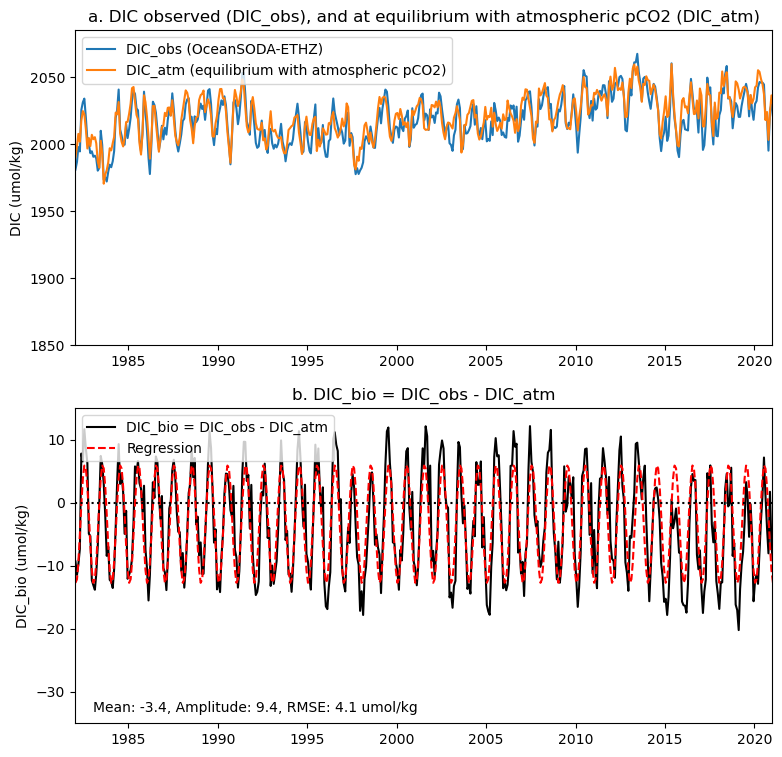

In [25]:
# San Francisco
i=236
j=127
fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    ''',
    figsize = (9, 9)
    # constrained_layout = True
)
# Plot at ['A']
ax['A'].plot(ds_dict["yearfrac"], ds_dict["dic"][:,j,i], label='DIC_obs (OceanSODA-ETHZ)', linestyle='-', marker='')
ax['A'].plot(ds_dict["yearfrac"], ds_dict["dic_atm"][:,j,i], label='DIC_atm (equilibrium with atmospheric pCO2)', linestyle='-')
# ax['A'].set_xlabel('year')
ax['A'].set_ylabel('DIC (umol/kg)')
ax['A'].legend(loc='upper left')
# ax['A'].grid(True)
ax['A'].set_title('a. DIC observed (DIC_obs), and at equilibrium with atmospheric pCO2 (DIC_atm)')
# ax['A'].set_xlim(2010, 2021)
ax['A'].set_xlim(1982, 2021)
ax['A'].set_ylim(1850, 2085)
# ax['A'].text(1983, 36.5, 'Mean: '+f"{A_fit:.1f}"+', Amplitude: '+f"{B_fit:.1f}"+', RMSE: '+f"{rmse:.1f}"+' umol/kg',
#         fontsize=10, color='black', ha='left', va='center')
# ax['A'].axhline(y=0, color='k', linestyle=':')
# Plot at ['B']
ax['B'].plot(ds_dict["yearfrac"], ds_dict["dic_bio"][:,j,i], label='DIC_bio = DIC_obs - DIC_atm', color='black', linestyle='-', marker='')
ax['B'].plot(ds_dict["yearfrac"], ds_dict["dic_bio_fit"][:,j,i], label='Regression', color='red', linestyle='--')
# ax['A'].set_xlabel('year')
ax['B'].set_ylabel('DIC_bio (umol/kg)')
ax['B'].legend(loc='upper left')
# ax['B'].grid(True)
ax['B'].set_title('b. DIC_bio = DIC_obs - DIC_atm')
# ax['B'].set_xlim(2010, 2021)
ax['B'].set_xlim(1982, 2021)
# ax['B'].text(1983, -10, 'Mean: '+f"{A_fit:.1f}"+', Amplitude: '+f"{B_fit:.1f}"+', RMSE: '+f"{rmse:.1f}"+' umol/kg',
#         fontsize=10, color='black', ha='left', va='center')
ax['B'].text(1983, -32.5, 'Mean: '+f"{ds_dict["dic_bio_mean"][j,i]:.1f}"+', Amplitude: '+f"{ds_dict["dic_bio_amplitude"][j,i]:.1f}"+', RMSE: '+f"{ds_dict["dic_bio_rmse"][j,i]:.1f}"+' umol/kg',
        fontsize=10, color='black', ha='left', va='center')
ax['B'].set_ylim(-35, 15)
ax['B'].axhline(y=0, color='k', linestyle=':')
fig.savefig('Fig10_DIC_obs_atm_bio_at_SanFrancisco_1982_2020_fco2atm_as_fco2_v3.png', format='png');

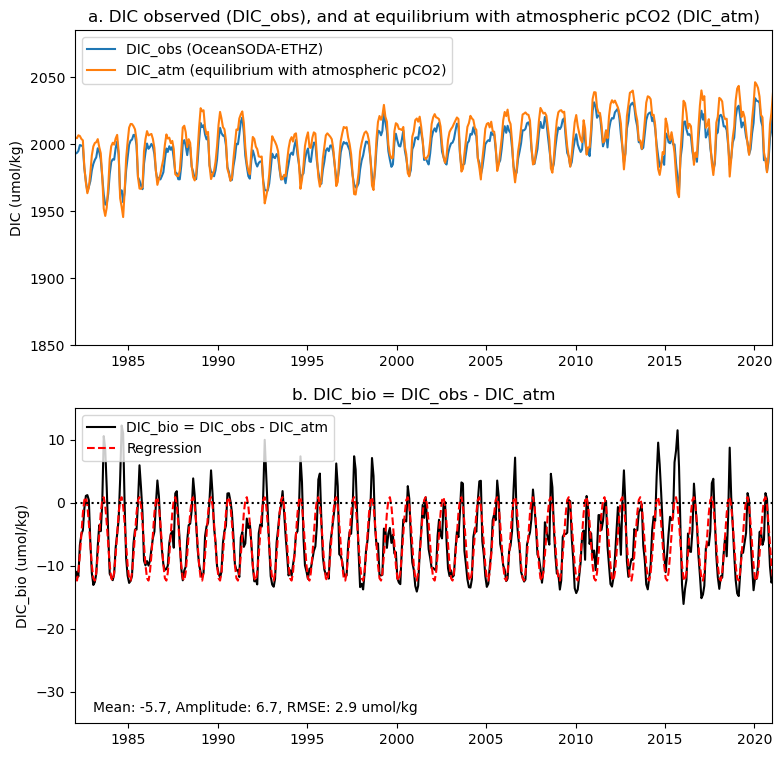

In [26]:
# Huntington
i=241
j=122
fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    ''',
    figsize = (9, 9)
    # constrained_layout = True
)
# Plot at ['A']
ax['A'].plot(ds_dict["yearfrac"], ds_dict["dic"][:,j,i], label='DIC_obs (OceanSODA-ETHZ)', linestyle='-', marker='')
ax['A'].plot(ds_dict["yearfrac"], ds_dict["dic_atm"][:,j,i], label='DIC_atm (equilibrium with atmospheric pCO2)', linestyle='-')
# ax['A'].set_xlabel('year')
ax['A'].set_ylabel('DIC (umol/kg)')
ax['A'].legend(loc='upper left')
# ax['A'].grid(True)
ax['A'].set_title('a. DIC observed (DIC_obs), and at equilibrium with atmospheric pCO2 (DIC_atm)')
# ax['A'].set_xlim(2010, 2021)
ax['A'].set_xlim(1982, 2021)
ax['A'].set_ylim(1850, 2085)
# ax['A'].text(1983, 36.5, 'Mean: '+f"{A_fit:.1f}"+', Amplitude: '+f"{B_fit:.1f}"+', RMSE: '+f"{rmse:.1f}"+' umol/kg',
#         fontsize=10, color='black', ha='left', va='center')
# ax['A'].axhline(y=0, color='k', linestyle=':')
# Plot at ['B']
ax['B'].plot(ds_dict["yearfrac"], ds_dict["dic_bio"][:,j,i], label='DIC_bio = DIC_obs - DIC_atm', color='black', linestyle='-', marker='')
ax['B'].plot(ds_dict["yearfrac"], ds_dict["dic_bio_fit"][:,j,i], label='Regression', color='red', linestyle='--')
# ax['A'].set_xlabel('year')
ax['B'].set_ylabel('DIC_bio (umol/kg)')
ax['B'].legend(loc='upper left')
# ax['B'].grid(True)
ax['B'].set_title('b. DIC_bio = DIC_obs - DIC_atm')
# ax['B'].set_xlim(2010, 2021)
ax['B'].set_xlim(1982, 2021)
# ax['B'].text(1983, -10, 'Mean: '+f"{A_fit:.1f}"+', Amplitude: '+f"{B_fit:.1f}"+', RMSE: '+f"{rmse:.1f}"+' umol/kg',
#         fontsize=10, color='black', ha='left', va='center')
ax['B'].text(1983, -32.5, 'Mean: '+f"{ds_dict["dic_bio_mean"][j,i]:.1f}"+', Amplitude: '+f"{ds_dict["dic_bio_amplitude"][j,i]:.1f}"+', RMSE: '+f"{ds_dict["dic_bio_rmse"][j,i]:.1f}"+' umol/kg',
        fontsize=10, color='black', ha='left', va='center')
ax['B'].set_ylim(-35, 15)
ax['B'].axhline(y=0, color='k', linestyle=':')
fig.savefig('Fig11_DIC_obs_atm_bio_at_Huntington_1982_2020_fco2atm_as_fco2_v3.png', format='png');

# Save ds_dict as mat file

Now that we have invested signficant computational resources to calculate the biological component of DIC, next we will save the results so far in a mat file. This will allow us to quickly load these new variables back into the dictionary of numpy arrays (ds_dict) in our notebook in case we take a break for some reason to close the notebook and then we later want to start from where we left off to continue the analysis.

In [27]:
import scipy.io

# uncomment one of the lines below to either save or load a at file of results

# Save the results in ds_dict to a mat file 
scipy.io.savemat('OceanSODA_ETHZ_for_PyOAE_with_DICbio_v3.mat', ds_dict)

# load previously saved mat file into ds_dict
# ds_dict = scipy.io.loadmat('OceanSODA_ETHZ_for_PyOAE_with_DICbio.mat')